# The Helmholtz equation


In this tutorial, we will learn:
 - How to discretize PDEs with complex-valued fields,
 - How to import and use high-order meshes from GMSH,
 - How to use high order discretizations,
 - How to use UFL expressions.

## Problem statement
We will solve the Helmholtz equation subject to a first order absorbing boundary condition:

$$
\begin{align*}
\Delta u + k^2 u &= 0 \qquad \text{in } \Omega,\\
\nabla u \cdot \mathbf{n} - jku &= g \qquad \text{on } \partial\Omega.
\end{align*}
$$ 
where $k$ is a pieciwise constant wavenumber, and $g$ is the boundary source term computed as:

$$g = \nabla u_i \cdot \mathbf{n} - jku_i$$

and $u_i$ is the incoming plane wave. 

In [1]:
from mpi4py import MPI
from dolfinx import fem
import ufl

We define some model parameters:

In [2]:
import numpy as np

# MPI communicator
comm = MPI.COMM_WORLD

# wavenumber in free space (air)
k0 = 10 * np.pi

# Corresponding wavelength
lmbda = 2 * np.pi / k0

# Polynomial degree
degree = 4

# Mesh order
mesh_order = 2

This code is only meant to be executed with complex-valued degrees of freedom. To be able to solve such problems, we use the complex build of PETSc.

In [3]:
import sys
from petsc4py import PETSc

if not np.issubdtype(PETSc.ScalarType, np.complexfloating):
    print("This tutorial requires complex number support")
    sys.exit(0)
else:
    print(f"Using {PETSc.ScalarType}.")

Using <class 'numpy.complex128'>.


We will use [GMSH](http://gmsh.info/) to generate the computational domain (mesh) for this example. As long as GMSH has been installed (including its Python API), DOLFINx supports direct input of GMSH models (generated on one process). DOLFINx will then in turn distribute the mesh over all processes in the communicator passed to `dolfinx.io.gmshio.model_to_mesh`.

## Interfacing with GMSH

The function `generate_mesh` creates a GMSH model on rank 0 of `MPI.COMM_WORLD`.

In [4]:
try:
    import gmsh
except ModuleNotFoundError:
    print("This demo requires gmsh to be installed")
    sys.exit(0)

In [5]:
import gmsh
from dolfinx.io import gmshio
from mesh_generation import generate_mesh

gmsh.initialize()
model = generate_mesh(lmbda, order=mesh_order)
mesh, cell_tags, _ = gmshio.model_to_mesh(model, comm, 0, gdim=2)
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Circle)
Info    : [ 90%] Meshing curve 6 (Circle)
Info    : Done meshing 1D (Wall 0.0021821s, CPU 0.00166s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0404163s, CPU 0.024793s)
Info    : 507 nodes 1032 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 30%] Meshing curve 3 order 2
Info    : [ 40%] Meshing curve 4 order 2
Info    : [ 50%] Meshing curve 5 order 2
Info    : [ 60%] Meshing curve 6 order 2
Info    : [ 70%] Meshing surface 1 order 2
Info    : [ 80%] Meshing surface 2 orde

## Material parameters and boundary conditions

In this problem, the wave number in the different parts of the domain depends on cell markers, inputted through `cell_tags`.
We use the fact that a Discontinuous Galerkin space of order 0 (cell-wise piecewise constants) has a one-to-one mapping with the cells local to the process.

In [6]:
DG = fem.FunctionSpace(mesh, ("DG", 0))
k = fem.Function(DG)
k.x.array[:] = k0
k.x.array[cell_tags.find(1)] = 2*k0

Now we can visualize the wavenumber distribution throughout the computational domain:

In [7]:
import pyvista
import matplotlib.pyplot as plt
from dolfinx.plot import create_vtk_mesh

pyvista.set_jupyter_backend("pythreejs")

topology, cells, geometry = create_vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.cell_data["Marker"] = k.x.array.real
plotter = pyvista.Plotter()
renderer = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

2022-08-10 12:54:20.130 (   3.890s) [        E6664000]    vtkExtractEdges.cxx:435   INFO| Executing edge extractor: points are renumbered
2022-08-10 12:54:20.134 (   3.895s) [        E6664000]    vtkExtractEdges.cxx:551   INFO| Created 5712 edges


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

Next, we define the boundary source term, by using `ufl.SpatialCoordinate`. When using this function, all quantities using this expression will be evaluated at quadrature points.

In [8]:
n = ufl.FacetNormal(mesh)
x = ufl.SpatialCoordinate(mesh)
ui = ufl.exp(-1j * k * x[0])
g = ufl.dot(ufl.grad(ui), n) + 1j * k * ui

## Variational form

Next, we can define the variational problem, using a 4th order Lagrange space. Note that as we are using complex valued functions, we have to use the appropriate inner product, see [DOLFINx tutorial: Complex numbers](https://jorgensd.github.io/dolfinx-tutorial/chapter1/complex_mode.html) for more information.


$$ -\int_\Omega \nabla u \cdot \nabla \bar{v} ~ dx + \int_\Omega k^2 u \,\bar{v}~ dx - j\int_{\partial \Omega} ku  \bar{v} ~ ds = \int_{\partial \Omega} g \, \bar{v}~ ds \qquad \forall v \in \widehat{V}. $$

In [9]:
element = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), degree)
V = fem.FunctionSpace(mesh, element)
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
ds = ufl.Measure("ds", domain=mesh)
dx = ufl.Measure("dx", domain=mesh)
a = -ufl.inner(ufl.grad(u), ufl.grad(v)) * dx \
    + k**2 * ufl.inner(u, v) * dx \
    - 1j * k * ufl.inner(u, v) * ds
L = ufl.inner(g, v) * ds

## Linear solver

Next, we will solve the problem using a direct solver (LU).

In [10]:
opt = {"ksp_type": "preonly", "pc_type": "lu"}
problem = fem.petsc.LinearProblem(a, L, petsc_options=opt)
uh = problem.solve()
uh.name = "u"

## Visualizing the complex solution

In [11]:
import pyvista
import matplotlib.pyplot as plt
from dolfinx.plot import create_vtk_mesh

pyvista.set_jupyter_backend("pythreejs")

topology, cells, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.cell_data["Marker"] = k.x.array.real
plotter.close()
plotter = pyvista.Plotter()
renderer = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

2022-08-10 12:55:12.319 (  56.149s) [        E6664000]    vtkExtractEdges.cxx:435   INFO| Executing edge extractor: points are renumbered
2022-08-10 12:55:12.334 (  56.164s) [        E6664000]    vtkExtractEdges.cxx:551   INFO| Created 22704 edges


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

In [12]:
topology, cells, geometry = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cells, geometry)
grid.point_data["Re(u)"] = uh.x.array.real
grid.point_data["Im(u)"] = uh.x.array.imag

In [13]:
pyvista.start_xvfb(0.5) # Start virtual framebuffer for plotting

In [14]:
import matplotlib.pyplot as plt

plotter = pyvista.Plotter()
grid.set_active_scalars("Re(u)")
renderer = plotter.add_mesh(grid, show_edges=False)
img = plotter.screenshot("Re_u.png",
                         transparent_background=True,
                         window_size=(1000,1000))

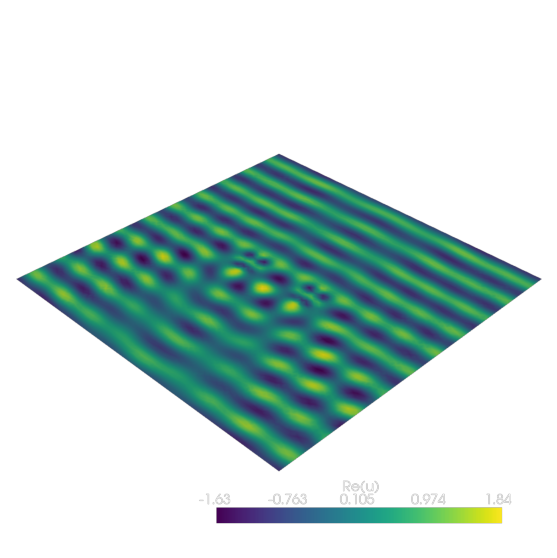

In [16]:
plt.axis("off")
plt.gcf().set_size_inches(10,10)
fig = plt.imshow(img)

In [17]:
plotter_im = pyvista.Plotter()
grid.set_active_scalars("Im(u)")
renderer = plotter_im.add_mesh(grid, show_edges=False)
img = plotter_im.screenshot("Im_u.png",
                         transparent_background=True,
                         window_size=(1000,1000))

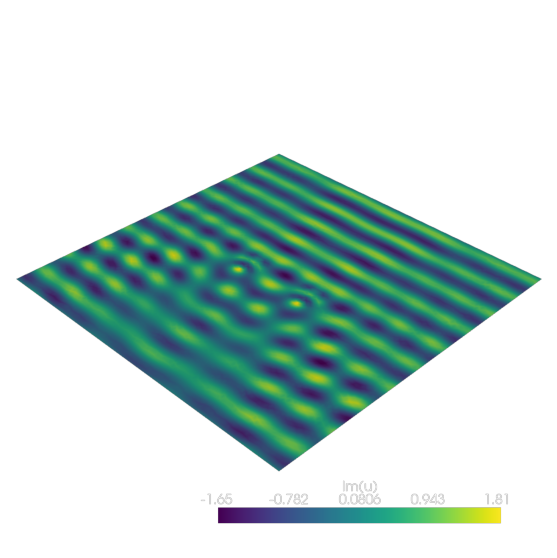

In [18]:
plt.axis("off")
plt.gcf().set_size_inches(10,10)
fig = plt.imshow(img)

## Saving higher order functions

In [20]:
from dolfinx.io import XDMFFile, VTXWriter

# XDMF write the solution as a P1 function
with XDMFFile(comm, "out.xdmf", "w") as file:
    file.write_mesh(mesh)
    file.write_function(uh)

# VTX can write higher order function
with VTXWriter(comm, "out_high_order.bp", [uh]) as f:
    f.write(0.0)